In [ ]:
from keras.models import Model,Sequential
import numpy as  np
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, merge, Conv2D,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, Callback
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.python import keras
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras.layers import Conv3D, MaxPooling3D, concatenate, UpSampling3D
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # Don't change this.
imgarray=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended flair/flair.npy')
maskarray=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended masks/masks.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x_train1,x_test,y_train1,y_test=train_test_split(imgarray, maskarray, test_size = 0.20, random_state = 101)

In [ ]:
x_train1.shape,y_train1.shape

((156, 128, 128, 128), (156, 128, 128, 128))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size = 0.20, random_state = 101)

In [ ]:
x_train.shape,x_val.shape

((124, 128, 128, 128), (32, 128, 128, 128))

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))



In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))



In [ ]:
def segnet():#,savename):

    # Encoding layer
    img_input = Input(shape= (128,128,128))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    print("x.shape",x.shape)
    pred = Reshape((128,128,128))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(learning_rate=0.0001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    #hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    
    #model.save(savename)
    return model#,hist

In [ ]:
y_train.shape,x_train.shape

((124, 128, 128, 128), (124, 128, 128, 128))

In [ ]:
model = segnet()#'segnet_1_epoch.h5')
hist = model.fit(x_train, y_train, epochs= 100, batch_size= 18, validation_data= (x_val, y_val), verbose=1)

In [ ]:
model_0=model
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

7/7 [==============================] - 1s 110ms/step - loss: 0.4896 - iou: 0.7622 - dice_coef: 0.2903 - precision: 0.1903 - recall: 0.9863 - accuracy: 0.7547
________________________
IOU:       |   76.22  |
Dice Coef: |   29.03  |
Precision: |   19.03  |
Recall:    |   98.63  |
Accuracy:  |   75.47  |
Loss:      |   48.96  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 1s 248ms/step - loss: 0.5975 - iou: 0.7567 - dice_coef: 0.2169 - precision: 0.1989 - recall: 0.9632 - accuracy: 0.7664
________________________
IOU:       |   75.67  |
Dice Coef: |   21.69  |
Precision: |   19.89  |
Recall:    |   96.32  |
Accuracy:  |   76.64  |
Loss:      |   59.75  |
________________________

-------------On validation Set---------------------

2/2 [==============================] - 0s 88ms/step - loss: 0.5770 - iou: 0.7511 - dice_coef: 0.2383 - precision: 0.1976 - recall: 0.9579 - accuracy: 0.7518
________________________
IOU:  

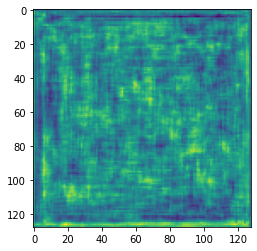

In [ ]:
plt.imshow(preds[8,:,:,2])